<a href="https://colab.research.google.com/github/Yoo-Hyuna/MANDOOPI/blob/main/%EB%91%90%ED%94%BC_%EB%B6%84%EB%A5%98_%ED%95%99%EC%8A%B5_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from google.colab import drive
import random
import shutil
import time
import datetime
import copy
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# 퓨리에변환

In [ ]:
#source_folder: 원본 이미지 최상위 폴더
#output_folder: 변환된 이미지 저장

os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# Fourier 변환 수행
def fourier_transform_image(image_path, save_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)  # 주파수 중심 이동
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # 크기 스펙트럼 이미지로 변환 결과 저장
    plt.imsave(save_path, magnitude_spectrum, cmap='gray')
    print(f"저장 완료: {save_path}")

# 이미지/라벨 데이터 train, test, validation split

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_seed = 100
random.seed(random_seed)
torch.manual_seed(random_seed)

In [ ]:
#model1~6: 6가지 증상

train_name = 'model1'

hyper_param_batch = 1 #hyper_param_batch = 6
num_epochs = 100

In [ ]:
# 데이터경로
data_train_path ='/train_data/'+train_name+'/train'
data_validation_path = '/train_data/'+train_name+'/validation'
data_test_path = '/train_data/'+train_name+'/test'

PATH ='/save_model/'

In [ ]:
#모델 불러오기
model_name = 'efficientnet-b7'
num_classes = 4
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [ ]:
#이미지 전처리
def func(x):
    return x.rotate(90)

transforms_train = transforms.Compose([
    transforms.Resize([int(600), int(600)], interpolation=transforms.InterpolationMode.BOX),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Lambda(func),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transforms_val = transforms.Compose([
    transforms.Resize([int(600), int(600)], interpolation=transforms.InterpolationMode.BOX),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data_set = datasets.ImageFolder(root = data_train_path, transform=transforms_train)
val_data_set = datasets.ImageFolder(root = data_validation_path, transform=transforms_val)

In [ ]:
#폴더별로 나뉘어진 data 라벨링
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(train_data_set,
                                  batch_size=hyper_param_batch,
                                  shuffle=True,
                                  num_workers=4)
dataloaders['val'] = DataLoader(val_data_set,
                                batch_size=hyper_param_batch,
                                shuffle=False,
                                num_workers=4)
batch_num['train'], batch_num['val'] = len(train_data_set), len(val_data_set)
print('batch_size : %d,  train/val : %d / %d' % (hyper_param_batch, batch_num['train'], batch_num['val']))

batch_size : 1,  train/val : 283 / 93


# 모델 학습

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # 훈련 시작 시간 기록
    start_time = time.time()
    since = time.time()
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # 손실 및 정확도 기록을 위한 리스트 초기화
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_start = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_cnt = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # 기울기 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)  # 손실 합산
                running_corrects += torch.sum(preds == labels.data)  # 올바른 예측 개수 합산
                num_cnt += len(labels)  # 총 샘플 수 합산

            if phase == 'train':
                scheduler.step()

            # 에폭 손실 및 정확도 계산
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc = float((running_corrects.double() / num_cnt).cpu() * 100)

            # 손실 및 정확도 기록
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('==> best model saved - %d / %.1f' % (best_idx, best_acc))

            epoch_end = time.time() - epoch_start
            print('Training epochs {} in {:.0f}m {:.0f}s'.format(epoch, epoch_end // 60, epoch_end % 60))
            print()
            torch.cuda.empty_cache()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' % (best_idx, best_acc))

    # best 모델 가중치 로드
    model.load_state_dict(best_model_wts)

    #모델+가중치 합쳐서 save -> 안드로이드 스튜디오
    torch.save(model, PATH + 'save_' + train_name + '.pt')
    print('model saved')

    # 학습 종료 시간 출력
    end_sec = time.time() - start_time
    end_times = str(datetime.timedelta(seconds=end_sec)).split('.')
    end_time = end_times[0]
    print("end time :", end_time)

    # 학습 및 검증 손실, 정확도 시각화
    epochs = range(num_epochs)

    plt.figure(figsize=(14, 6))

    #적절한 에폭 찾기

    # 손실 그래프 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, best_idx, best_acc, train_loss, train_acc, val_loss, val_acc



['0.양호', '1.경증', '2.중등도', '3.중증']


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(),lr = 1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/19
----------
train Loss: 1.3459 Acc: 31.6456
Training epochs 0 in 2m 16s

val Loss: 1.7776 Acc: 11.5385
==> best model saved - 0 / 11.5
Training epochs 0 in 2m 43s

Epoch 1/19
----------
train Loss: 1.3353 Acc: 35.4430
Training epochs 1 in 2m 14s

val Loss: 1.4960 Acc: 15.3846
==> best model saved - 1 / 15.4
Training epochs 1 in 2m 27s

Epoch 2/19
----------
train Loss: 1.2989 Acc: 36.2025
Training epochs 2 in 2m 14s

val Loss: 1.5244 Acc: 21.5385
==> best model saved - 2 / 21.5
Training epochs 2 in 2m 27s

Epoch 3/19
----------
train Loss: 1.2841 Acc: 40.2532
Training epochs 3 in 2m 14s

val Loss: 1.3607 Acc: 36.1538
==> best model saved - 3 / 36.2
Training epochs 3 in 2m 27s

Epoch 4/19
----------
train Loss: 1.2120 Acc: 44.0506
Training epochs 4 in 2m 14s

val Loss: 1.3267 Acc: 37.6923
==> best model saved - 4 / 37.7
Training epochs 4 in 2m 27s

Epoch 5/19
----------
train Loss: 1.1828 Acc: 42.5316
Training epochs 5 in 2m 15s

val Loss: 1.7608 Acc: 28.4615
Training epochs 5

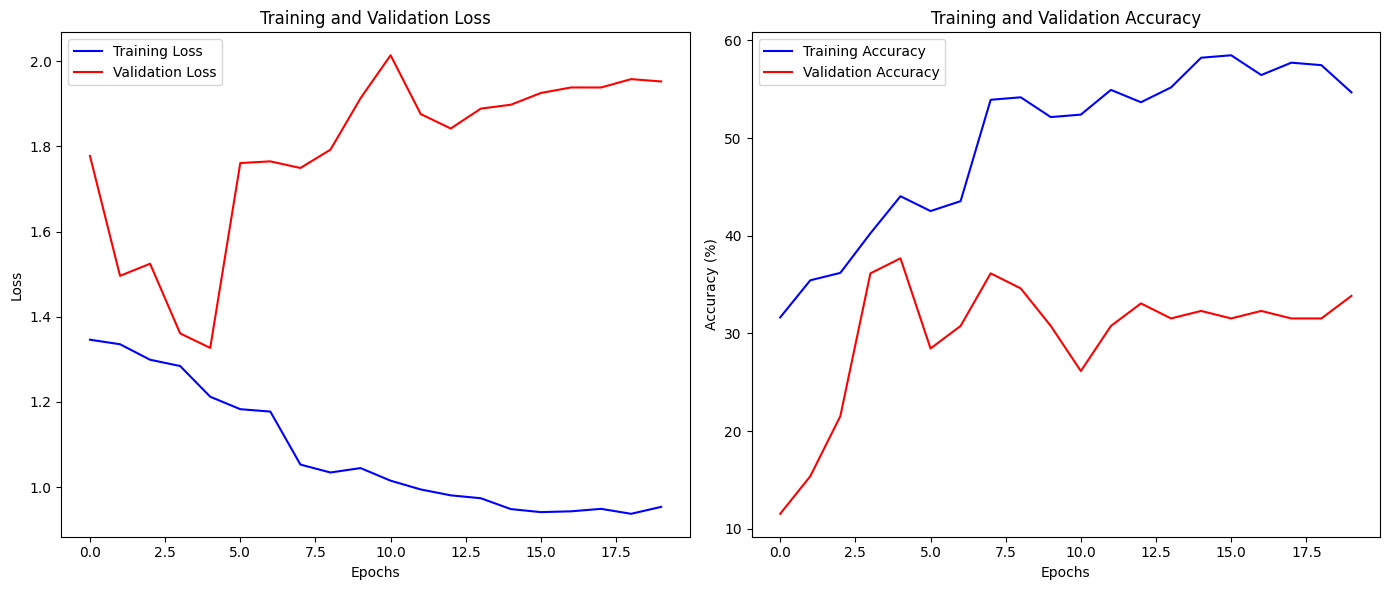

(EfficientNet(
   (_conv_stem): Conv2dStaticSamePadding(
     3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
     (static_padding): ZeroPad2d((0, 1, 0, 1))
   )
   (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (_blocks): ModuleList(
     (0): MBConvBlock(
       (_depthwise_conv): Conv2dStaticSamePadding(
         64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
         (static_padding): ZeroPad2d((1, 1, 1, 1))
       )
       (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
       (_se_reduce): Conv2dStaticSamePadding(
         64, 16, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_se_expand): Conv2dStaticSamePadding(
         16, 64, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_project_conv): Conv2dStaticSamePadding(
         64, 32, kernel_size=(1, 1), strid

In [ ]:
# def 실행

#model2 에폭20
train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 1.3798 Acc: 27.9152
Training epochs 0 in 1m 37s

val Loss: 1.4993 Acc: 15.0538
==> best model saved - 0 / 15.1
Training epochs 0 in 1m 46s

Epoch 1/99
----------
train Loss: 1.3723 Acc: 29.3286
Training epochs 1 in 1m 36s

val Loss: 1.5735 Acc: 17.2043
==> best model saved - 1 / 17.2
Training epochs 1 in 1m 46s

Epoch 2/99
----------
train Loss: 1.3703 Acc: 30.3887
Training epochs 2 in 1m 36s

val Loss: 1.6201 Acc: 16.1290
Training epochs 2 in 1m 45s

Epoch 3/99
----------
train Loss: 1.3706 Acc: 32.1555
Training epochs 3 in 1m 37s

val Loss: 1.5009 Acc: 20.4301
==> best model saved - 3 / 20.4
Training epochs 3 in 1m 46s

Epoch 4/99
----------
train Loss: 1.3462 Acc: 38.5159
Training epochs 4 in 1m 37s

val Loss: 1.6422 Acc: 16.1290
Training epochs 4 in 1m 45s

Epoch 5/99
----------
train Loss: 1.3763 Acc: 26.5018
Training epochs 5 in 1m 37s

val Loss: 1.6338 Acc: 16.1290
Training epochs 5 in 1m 45s

Epoch 6/99
----------
train Loss: 1.3733 Acc: 25.795

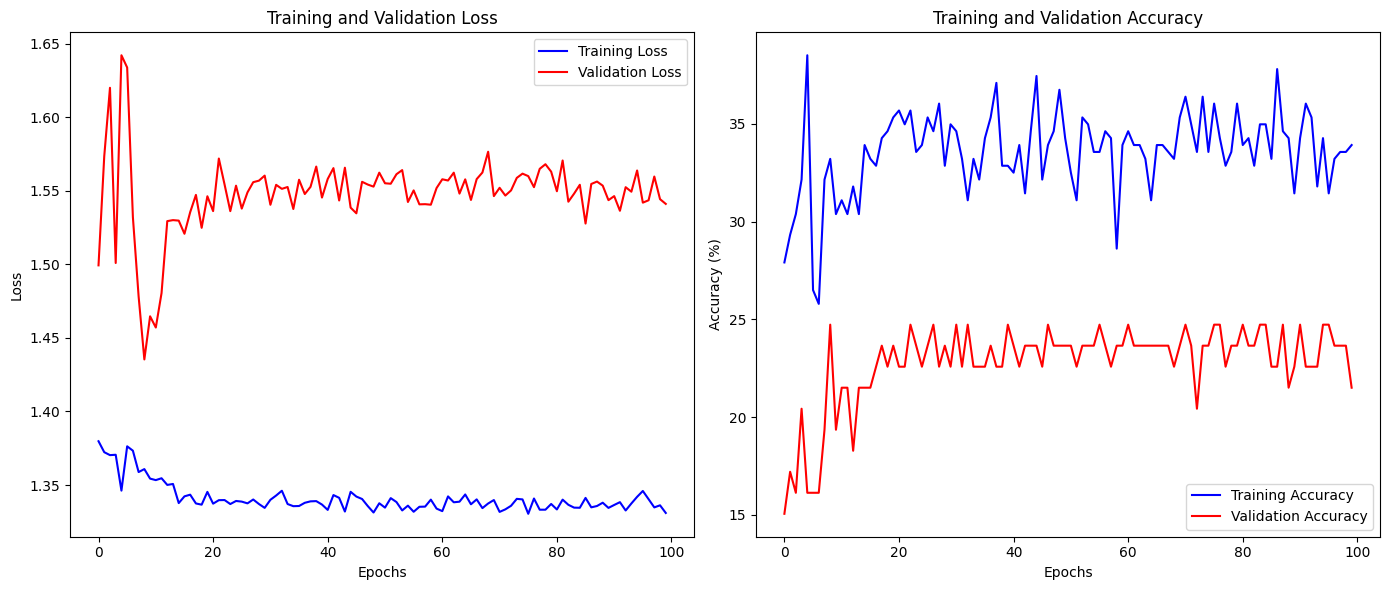

(EfficientNet(
   (_conv_stem): Conv2dStaticSamePadding(
     3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
     (static_padding): ZeroPad2d((0, 1, 0, 1))
   )
   (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (_blocks): ModuleList(
     (0): MBConvBlock(
       (_depthwise_conv): Conv2dStaticSamePadding(
         64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
         (static_padding): ZeroPad2d((1, 1, 1, 1))
       )
       (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
       (_se_reduce): Conv2dStaticSamePadding(
         64, 16, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_se_expand): Conv2dStaticSamePadding(
         16, 64, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_project_conv): Conv2dStaticSamePadding(
         64, 32, kernel_size=(1, 1), strid

In [ ]:
# model1 에폭 100 - data적은 증상(모델)
train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# 최적화 및 모델 시각화

In [ ]:
#에폭 고정 후 베이지안 최적화


from torchvision import models

# 베이지안 최적화 수행
best_optimizer = bayesian_optimization(train_model, pbounds, init_points=3, n_iter=5)

# 최적의 학습률로 데이터 로더 준비
best_params = best_optimizer.max['params']
best_lr = best_params['lr']

dataloaders = get_dataloaders(batch_size=1)  # 고정된 배치 사이즈 사용

# 모델 초기화 함수 정의
def initialize_model():
    model = models.efficientnet_b7(pretrained=False)  # EfficientNet 모델 초기화
    return model.to(device)

In [ ]:
from torch.utils.data import Dataset,DataLoader

# 경로에 저장된 모델 불러오기
PATH_test = '/content/drive/MyDrive/scalp_project/scalp_weights/aram_model1.pt'   # 모델경로

model1 = torch.load(PATH_test, map_location=device)
transforms_test = transforms.Compose([
                                        transforms.Resize([int(100), int(100)], interpolation=transforms.InterpolationMode.BICUBIC),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

testset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/scalp_project/train_data/model1/test',
					transform = transforms_test)
testset.__getitem__(0)[0].shape  # (0) 테스트셋의 0번째 item


<ipython-input-43-b4b1badb32a2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load(PATH_test, map_location=device)


torch.Size([3, 100, 100])

In [ ]:
from torch.utils.data import Dataset,DataLoader
testloader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

output_list = []
correct = 0

In [ ]:
# 데이터셋에서 첫 번째 데이터
inputs, labels = testset[0]
inputs = inputs.unsqueeze(0).to(device)  # 배치 차원을 추가하고 GPU 또는 CPU로 이동

model1.eval()

# 모델을 사용하여 예측 수행 (연산 그래프 생성)
outputs = model1(inputs)

# 모델 구조 시각화 및 저장(PNG)
dot = make_dot(outputs, params=dict(model1.named_parameters()))
dot.render("simplified_model_structure", format="svg")

print("모델 구조 시각화 완료: 'model_structure.png' 파일로 저장되었습니다.")

모델 구조 시각화 완료: 'model_structure.png' 파일로 저장되었습니다.


모델 구조 시각화 완료: 'efficientnet_b7_structure.png' 파일로 저장되었습니다.


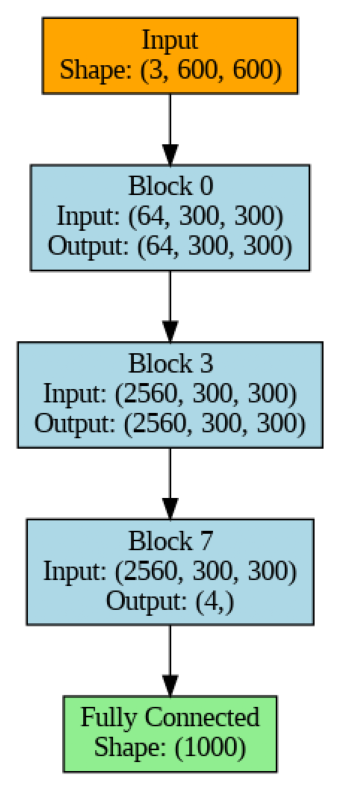

In [ ]:
import torch
import torchvision.models as models
from graphviz import Digraph
import matplotlib.pyplot as plt


# Graphviz 그래프 생성
# 레이어 구조 시각화 -> MVConv블록

def visualize_model_structure(model):
    dot = Digraph(format='png', engine='dot')
    dot.attr('node', shape='box', style='filled', fillcolor='lightblue')

    def add_layer(dot, name, input_shape, output_shape):
        label = f"{name}\nInput: {input_shape}\nOutput: {output_shape}"
        dot.node(name, label)

    # EfficientNet 모델의 각 레이어를 반복하여 블록 단위로 추가
    layers = list(model.children())
    input_shape = (3, 600, 600)  # 입력 이미지 크기 (채널 수 3, 600x600)

    # 입력 노드 추가
    dot.node('Input', 'Input\nShape: (3, 600, 600)', fillcolor='orange')

    prev_node = 'Input'

    # 블록별로 반복
    for idx, layer in enumerate(layers):
        name = f"Block {idx}"

        # 예시로 입력과 출력 크기를 설정
        output_shape = None

        if isinstance(layer, torch.nn.Conv2d):
            output_shape = (layer.out_channels, input_shape[1] // layer.stride[0], input_shape[2] // layer.stride[1])
            input_shape = output_shape

        elif isinstance(layer, torch.nn.MaxPool2d) or isinstance(layer, torch.nn.AvgPool2d):
            output_shape = (input_shape[0], input_shape[1] // layer.kernel_size, input_shape[2] // layer.kernel_size)
            input_shape = output_shape

        elif isinstance(layer, torch.nn.Linear):
            output_shape = (layer.out_features,)

        # 레이어 추가
        if output_shape is not None:
            add_layer(dot, name, input_shape, output_shape)
            dot.edge(prev_node, name)
            prev_node = name

    # 최종 Fully Connected (FC) 레이어 추가
    dot.node('FC', 'Fully Connected\nShape: (1000)', fillcolor='lightgreen')
    dot.edge(prev_node, 'FC')

    dot.render("efficientnet_b7_structure", format='png')
    print("모델 구조 시각화 완료: 'efficientnet_b7_structure.png' 파일로 저장되었습니다.")

visualize_model_structure(model)

# Matplotlib을 사용 생성된 이미지 반
img = plt.imread("efficientnet_b7_structure.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
